## Array Gain vs element spacing
This script plots linear antenna array gain vs. element spacing. As element spacing increase from $\lambda/2$ the array gain increases. However, as spacing gets closer to one wavelength, grating lobes start to apear in the visible region and that caus the gain to drop sharply. The same behaviour repaets with less gain variation when spacing increase from $\lambda$ to 2$\lambda$ and so on. Note that antenna array gain is the same for elemant spacing equal to  $\lambda/2$, $\lambda$,3$\lambda$/2,$2\lambda$ ... . 

In [99]:
from linear_array import LinearArray
import numpy as np
array_size = [4,8,16,32,64,128]
elem_spacing = np.linspace(0.5,2.5,101)
data = np.zeros((len(array_size),len(elem_spacing)))
for idx1,num_elem in enumerate(array_size):
    for idx2,element_spacing in enumerate(elem_spacing):
        la = LinearArray(num_elem,element_spacing,scan_angle=0,element_pattern=True) 
        la.calc_AF # calculate Array Factor (Array radiation pattern)
        params = la.calc_peak_sll_hpbw()
        data[idx1,idx2] = params.Gain


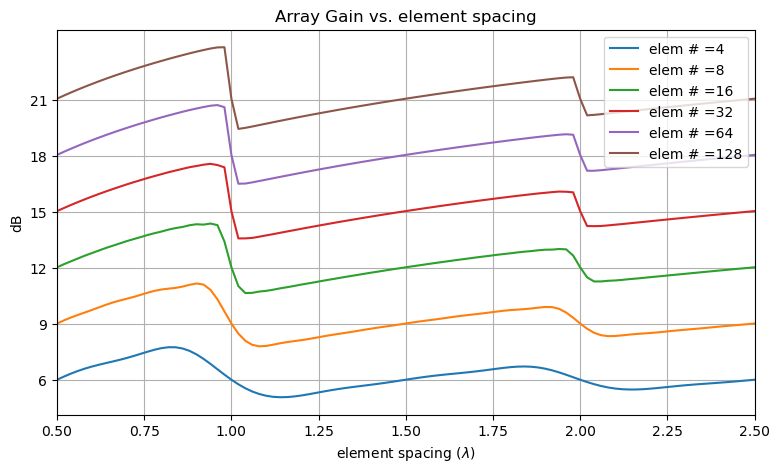

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize = (9,5))
plt.plot(elem_spacing,data.T)
plt.grid()
plt.yticks(np.floor(data[:,0]))
plt.xlim(elem_spacing[0],elem_spacing[-1])
plt.xlabel('element spacing ($\lambda$)')
plt.ylabel('dB')
plt.title('Array Gain vs. element spacing')
plt.legend([f'elem # ={x}' for x in array_size  ]);

## Side Lobe Level : Amplitude and Phase Error
We can evaluate the effect of amplitude and phase error of phase shifters on the performance of the antenna array. SLL is most sensitive to errors in excitation phase and amplitude.  In applications where low SLL is critical (Radars), one should reduce phase/amplitude error to gurantee the SLL requirement is met. 
Below, we evaluate the effect of phase/aplitude error on antenna array SLL by introding uniform error in excitation phase and magnitude. The results are illusterated in a contour graph where one can easily observe SLL degradation versus max phase and amlitude error.  

In [147]:
from antenna_array import calc_AF_, plot_pattern ,calc_peak_sll_hpbw, db20
import pandas as pd
from scipy.signal.windows import get_window , taylor, chebwin

df = pd.DataFrame(columns = ['Peak','SLL','HPBW'])

num_elem = 32
element_spacing = 0.5
X = np.linspace(0,num_elem-1,num_elem) * element_spacing
Nt = 721 # length of theta vectoe
theta_deg,dtheta_deg = np.linspace(-90,90,Nt,retstep = True)
theta_deg = theta_deg.reshape(Nt,1)
SLL_target = 30
max_phase_error = np.linspace(0,30,31) # in deg
max_mag_error = np.linspace(0,5,6) # in dB
SLL_data = np.zeros((len(max_phase_error),len(max_mag_error),1000))
for idx1,phase_error in enumerate(max_phase_error):
    for idx2,mag_error in enumerate(max_mag_error):
        
        if SLL_target < 50:    
            I = taylor(num_elem, nbar=5, sll=SLL_target)
        else:
            I = chebwin(num_elem, SLL_target)
        for Ntrail in range(1000):    
            P_deg = np.random.uniform(low=-phase_error, high=phase_error, size=num_elem)
            I = I / max(I)
            IdB = 20 * np.log10(I)

            IdB_err = IdB + np.random.uniform(low=-mag_error, high=mag_error, size=num_elem)
            I_err = 10**(IdB_err/20)
            AF_linear = calc_AF_(X,I_err,P_deg * np.pi / 180,theta_deg,element_pattern=False)
            G = db20(AF_linear)

            peak, theta_peak, SLL, HPBW = calc_peak_sll_hpbw(G, theta_deg)
            SLL_data[idx1,idx2,Ntrail] = SLL

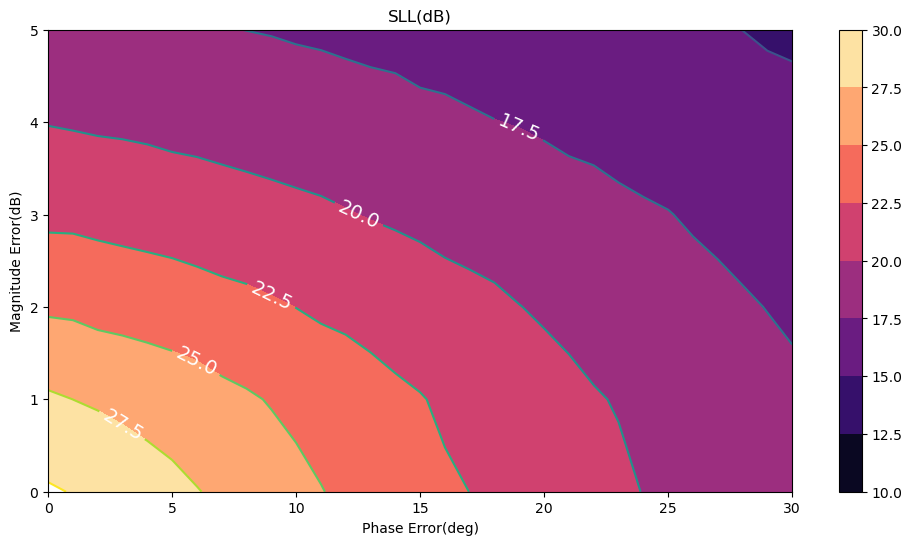

In [148]:
X, Y = np.meshgrid(max_phase_error, max_mag_error)
fig,ax = plt.subplots(figsize = (12,6))
plt.contourf(X,Y,np.mean(SLL_data,axis=2).T,np.linspace(10,30,9),cmap='magma')
plt.colorbar()
CS = plt.contour(X,Y,np.mean(SLL_data,axis=2).T,np.linspace(10,30,9))
ax.clabel(CS, fmt='%1.1f', colors='w', fontsize=14)
plt.xlabel('Phase Error(deg)')
plt.title('SLL(dB)')
plt.ylabel('Magnitude Error(dB)');
